In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
from tensorflow.keras import layers, models, regularizers

# Path to the downloaded dataset
dataset_dir = "archive"


# Function to load images and annotations
def load_dataset(dataset_dir):
    images_dir = os.path.join(dataset_dir, "images")
    annotations_dir = os.path.join(dataset_dir, "annotations")
    
    images = []
    labels = []
    for filename in os.listdir(annotations_dir):
        if filename.endswith(".xml"):
            xml_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                label = obj.find('name').text
                label = 'with_mask' if label == 'with_mask' else 'without_mask'  # Assuming binary classification
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                image_path = os.path.join(images_dir, root.find('filename').text)
                image = cv2.imread(image_path)
                image = image[ymin:ymax, xmin:xmax]  # Crop the image based on bounding box
                image = cv2.resize(image, (224, 224))  # Resize the image to a standard size
                images.append(image)
                labels.append(label)
    if not images or not labels:
        print("Error: No data loaded from the dataset.")
        return None, None
    
    return np.array(images), np.array(labels)

In [5]:
# Load the dataset
X, y = load_dataset(dataset_dir)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [6]:
set(y)

{'with_mask', 'without_mask'}

In [7]:
len(y)

4072

In [13]:
from collections import Counter
Counter(y)

Counter({'with_mask': 3232, 'without_mask': 840})

In [14]:
X.shape

(4072, 224, 224, 3)

In [15]:
y.shape

(4072,)

In [ ]:
import os 
import pandas as pd     
import numpy as np  
import cv2
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tqdm
import tensorflow as tf


In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(y)

labels_encoded = to_categorical(labels_encoded)

In [18]:
X.shape, y.shape

((4072, 224, 224, 3), (4072,))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, labels_encoded, test_size=0.30,stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50,stratify=y_test, random_state=42)

In [21]:
image_height = X.shape[1]
image_width = X.shape[2]
num_channels = X.shape[3]

In [24]:
image_height, image_width,num_channels

(224, 224, 3)

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,186 (84.86 MB)

 Trainable params: 22,245,186 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training with callbacks and validation set
history = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1,
                    validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.8378 - loss: 1.7308 - val_accuracy: 0.8232 - val_loss: 0.7027
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.8463 - loss: 0.6746 - val_accuracy: 0.7807 - val_loss: 0.9009
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.7953 - loss: 1.0348 - val_accuracy: 0.7921 - val_loss: 0.8341
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.7925 - loss: 0.8588 - val_accuracy: 0.7856 - val_loss: 0.8711
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.7865 - loss: 0.8834 - val_accuracy: 0.8020 - val_loss: 0.8159
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.7921 - loss: 0.7780 - val_accuracy: 0.7954 - val_loss: 0.6989


In [29]:
model.evaluate(X_test, y_test, verbose=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7850 - loss: 0.7443


[0.7127693891525269, 0.8166939616203308]

In [32]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

classification_rep = classification_report(y_test_labels, y_pred_labels)

print(classification_rep)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       485
           1       0.61      0.32      0.42       126

    accuracy                           0.82       611
   macro avg       0.72      0.63      0.65       611
weighted avg       0.79      0.82      0.79       611



In [33]:
# Find the class that was predicted wrong the most
wrong_predictions = np.where(y_pred_labels != y_test_labels)[0]
wrong_classes = y_test_labels[wrong_predictions]
most_wrong_class = Counter(wrong_classes).most_common(1)[0][0]

print(f"The class predicted wrong the most is: {most_wrong_class}")

The class predicted wrong the most is: 1


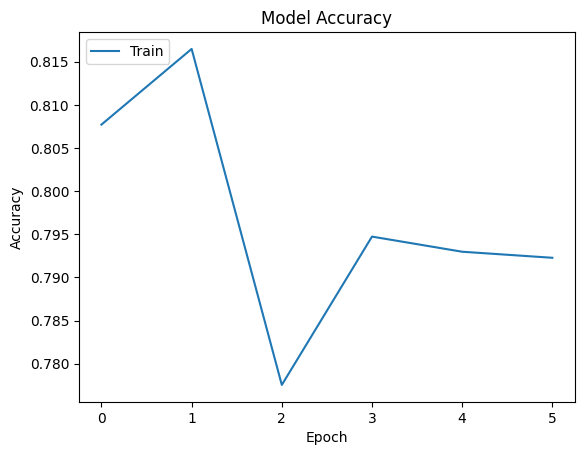

In [34]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

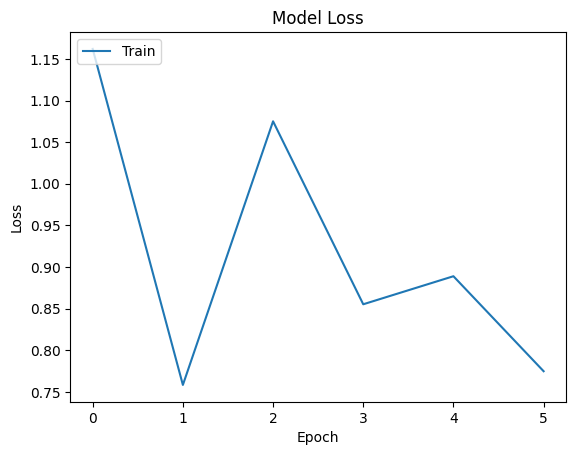

In [35]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step


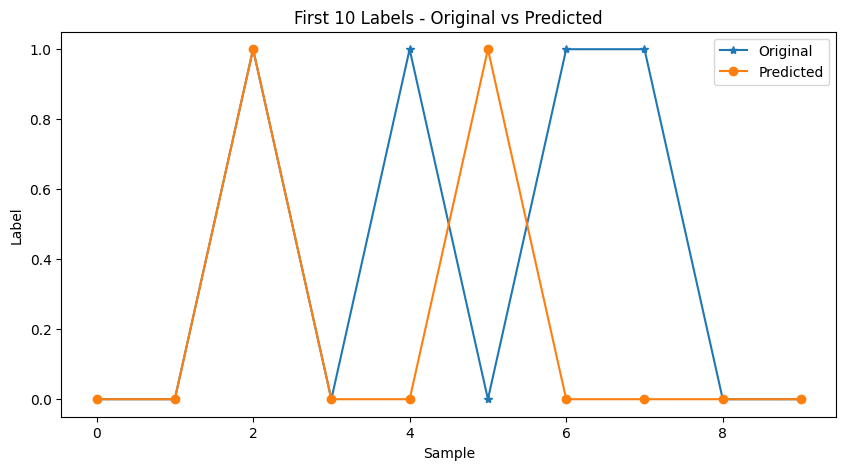

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_labels[:10], '*-', label='Original')
plt.plot(y_pred_labels[:10], 'o-', label='Predicted')
plt.title('First 10 Labels - Original vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend()
plt.show()

In [38]:
sample_labels_true = label_encoder.inverse_transform(y_test_labels)
sample_labels_pred = label_encoder.inverse_transform(y_pred_labels)

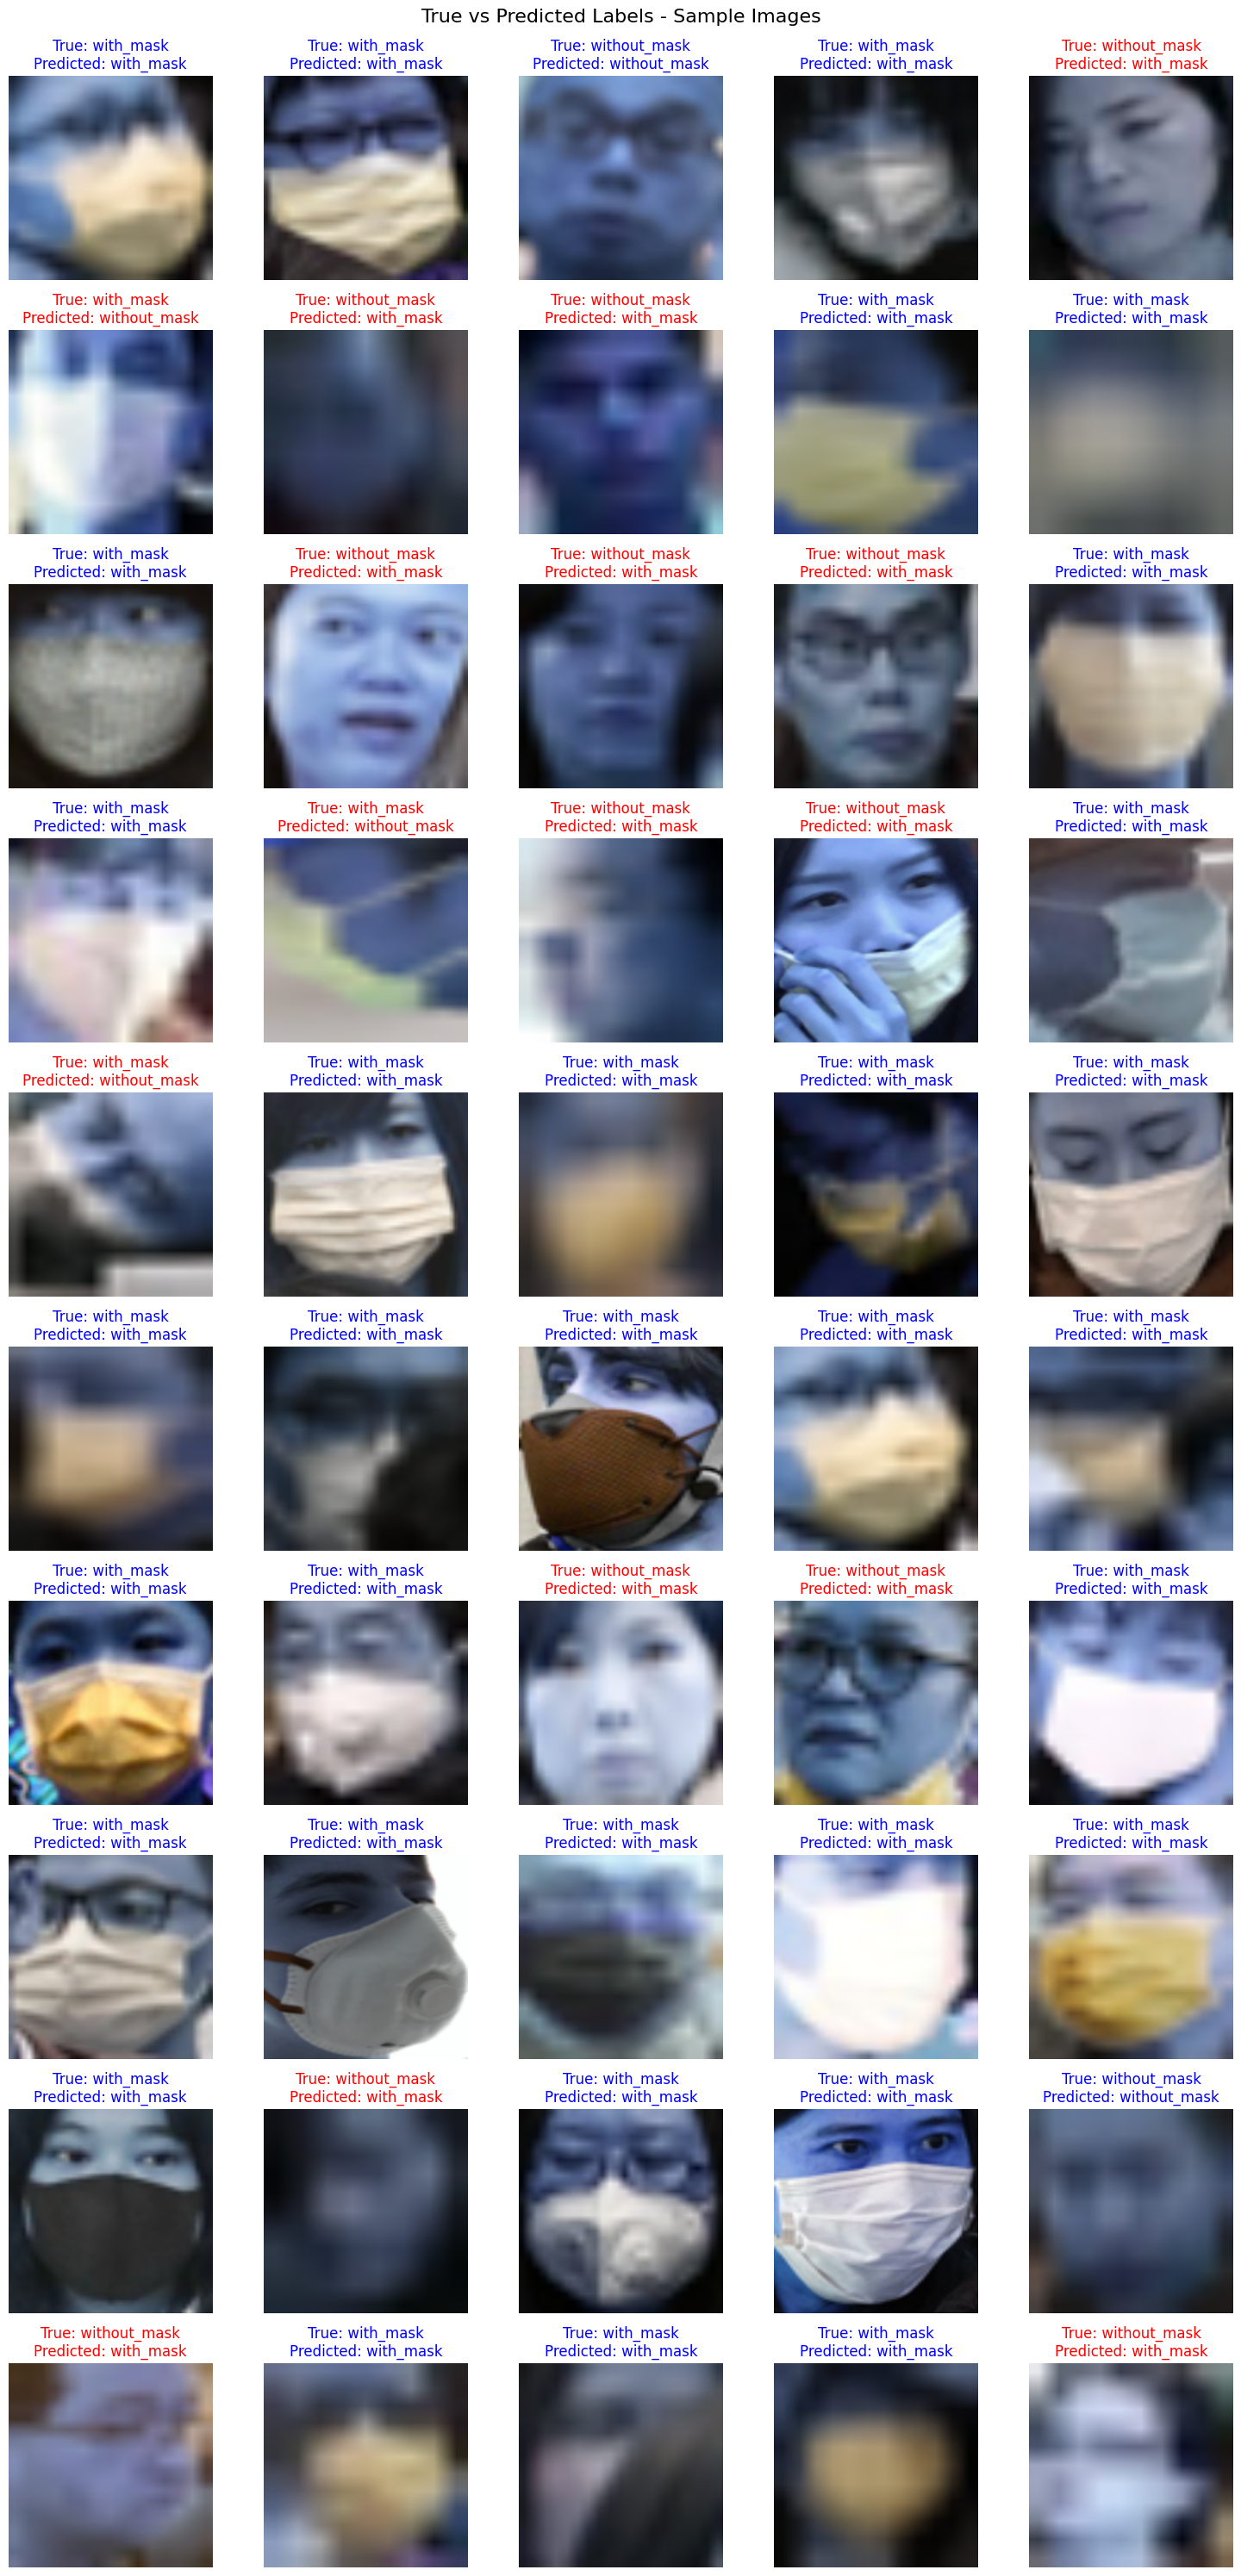

In [39]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15, 30))
fig.suptitle('True vs Predicted Labels - Sample Images', fontsize=16,y=0.995) 

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    title = ax.set_title(f'True: {sample_labels_true[i]}\nPredicted: {sample_labels_pred[i]}')
    if sample_labels_true[i] != sample_labels_pred[i]:
        title.set_color('red')
    else:
        title.set_color('blue')
    ax.axis('off')

plt.tight_layout()
plt.show()